In [197]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az

In [198]:
#### Preprocecing ###

In [199]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [200]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [201]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [202]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [203]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [204]:
### Data Preparation ###

In [223]:
country = 'Japan'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('today')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iter=2000
repeat = 1000

In [206]:
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
pd.to_datetime('2020-04-07')- epoch
data_2step = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0, 'ED':66}

In [207]:
### Model ###

In [208]:
sm_q0 = pystan.StanModel(file="turzin-start-q0.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64230a5b5384c44e11e41e1e07c52c66 NOW.


In [209]:
sm_0 = pystan.StanModel(file="turzin-start-0.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7cd556a42c7edab6d498f94c1bcf71f7 NOW.


In [210]:
sm_exp = pystan.StanModel(file="exponential.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4fc52bb8bc43e2438eebce6f0020e086 NOW.


In [211]:
sm_mlp = pystan.StanModel(file="turzin-multiple.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50dd240051e463766f65fd1d1be583af NOW.


In [224]:
# Train the model and generate samples
fit_start_q0 = sm_q0.sampling(data=data, iter=iter, init=0)
fit_start_q0


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_64230a5b5384c44e11e41e1e07c52c66.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  12.38    1.86    5.5   4.73   6.87  13.16   17.2  21.57      9    1.5
b0         0.12  7.3e-3   0.03   0.09    0.1   0.11   0.14   0.17     13   1.24
b1         0.11  2.9e-3 7.9e-3   0.09   0.11   0.12   0.12   0.12      8   2.68
theta_b    2.05    0.44    1.6   0.32    0.9    1.5   2.69   6.07     13   1.35
b_date    40.35    9.74  18.06   5.97   22.7  47.65  50.36  71.97      3   1.95
q0         0.92  7.1e-3   0.08    0.7    0.9   0.95   0.98    1.0    123   1.04
q1         0.38    0.03   0.09   0.12   0.37   0.41   0.43   0.48      9   1.82
theta_q    4.49    0.42   1.93   0.32   3.52    4.5    5.6   8.29     21    1.2
q_date    42.65    0.53   1.64  36.85  42.98  43.12

In [213]:
# Train the model and generate samples
fit_start_0 = sm_0.sampling(data=data, iter=iter, init=0)
fit_start_0


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7cd556a42c7edab6d498f94c1bcf71f7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   6.62    0.04   1.67   3.87   5.43   6.41    7.6  10.42   1512    1.0
b0         0.15  3.7e-4   0.01   0.12   0.14   0.14   0.15   0.17   1253    1.0
b1          0.1  1.7e-5 1.0e-3    0.1    0.1    0.1    0.1    0.1   3504    1.0
theta_b    1.62    0.02   1.11   0.37   0.82   1.32   2.13   4.51   2714    1.0
b_date    23.27    0.07   1.88  19.62  22.29  23.02  24.14   27.0    747   1.01
q1         0.88  1.8e-3    0.1   0.63   0.82   0.91   0.96    1.0   3194    1.0
theta_q    3.47    0.03   1.51   1.16   2.39   3.25   4.29   7.24   3570    1.0
q_date     0.21  3.1e-3   0.16 7.7e-3   0.08   0.18   0.31   0.59   2784    1.0
a          0.01  5.6e-6 3.3e-4 9.6e-310.0e-3   0.01

In [214]:
# Train the model and generate samples
fit_start_exp = sm_exp.sampling(data=data, iter=iter, init=0)
fit_start_exp


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_4fc52bb8bc43e2438eebce6f0020e086.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     13.14    0.02   0.82  11.62  12.57  13.11   13.7  14.79   1989    1.0
b              0.1  2.2e-5 9.6e-4    0.1    0.1    0.1    0.1    0.1   1893    1.0
a             0.01  6.6e-6 3.4e-4 9.6e-310.0e-3   0.01   0.01   0.01   2587    1.0
d           2.1e-3  2.8e-6 1.5e-4 1.8e-3 2.0e-3 2.1e-3 2.2e-3 2.4e-3   2895    1.0
NI[1]         1.33  1.6e-3   0.07    1.2   1.28   1.33   1.38   1.47   2023    1.0
NI[2]         1.45  1.7e-3   0.08   1.31    1.4   1.45    1.5    1.6   2024    1.0
NI[3]         1.58  1.8e-3   0.08   1.42   1.52   1.58   1.63   1.74   2024    1.0
NI[4]         1.72  2.0e-3   0.09   1.55   1.66   1.72   1.78    1.9   2025    1.0
NI[5]         1.87  2.1e

In [215]:
# Train the model and generate samples
fit_start_mlp = sm_mlp.sampling(data=data, iter=iter, init='random')
fit_start_mlp


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_50dd240051e463766f65fd1d1be583af.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    9.96    3.66   5.65   1.37   3.58  11.21  13.82  19.37      2   2.45
b0          0.14    0.06   0.09   0.01   0.06   0.14   0.24   0.28      2    3.7
b1          0.58    0.23   0.49   0.26   0.29   0.34   0.71   2.08      5    1.4
theta_b     1.44    0.92   1.53   0.07   0.22   0.28   2.44   5.04      3   1.85
b_date[1]   15.1     7.9  11.44   0.09   0.09  13.74  27.82  32.03      2   4.62
b_date[2]  20.47    10.6  15.02   1.76   6.66  17.99  36.21  43.34      2  16.66
b2          0.59    0.61   0.87   0.06   0.09   0.11   1.16   2.15      2  78.88
theta_b2    2.73    1.41   2.17   0.16   0.62   3.02    3.8    7.5      2   2.49
q0          0.42    0.22   0.32   0.13   0

In [216]:
### model selection

In [217]:
exp_data = az.from_pystan(fit_start_exp, log_likelihood='log_lik')
#start_0_data = az.from_pystan(fit_start_0, log_likelihood='log_lik')
start_q0_data = az.from_pystan(fit_start_q0, log_likelihood='log_lik')

In [218]:
az.loo(exp_data)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 76 log-likelihood matrix

       Estimate       SE
IC_loo  3637.27   806.98
p_loo    118.29        -

There has been a warning during the calculation. Please check the results.

In [219]:
az.loo(start_q0_data)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 4000 by 76 log-likelihood matrix

       Estimate       SE
IC_loo  3927.98   879.50
p_loo    690.30        -

There has been a warning during the calculation. Please check the results.

In [220]:
az.loo(start_0_data)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 86 log-likelihood matrix

       Estimate       SE
IC_loo  3930.56   843.30
p_loo    452.92        -

There has been a warning during the calculation. Please check the results.

In [168]:
az.compare({'exp':exp_data, 'start-q0':start_q0_data})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
start-q0,0,3409.56,169.001,0,0.892855,802.514,0,True,deviance
exp,1,3584.78,124.05,175.221,0.107145,807.033,151.541,True,deviance


In [169]:
### Visualization functions ###

In [170]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [171]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    S0 = [0]
    R0 = [0]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [172]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        try:
            q0 = fit['q0'][i]
        except:
            q0 = 0
        
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=q0,
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [173]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [174]:
def draw(simulated, real=None, upto=pd.to_datetime('today')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [175]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit_start_q0, 120)

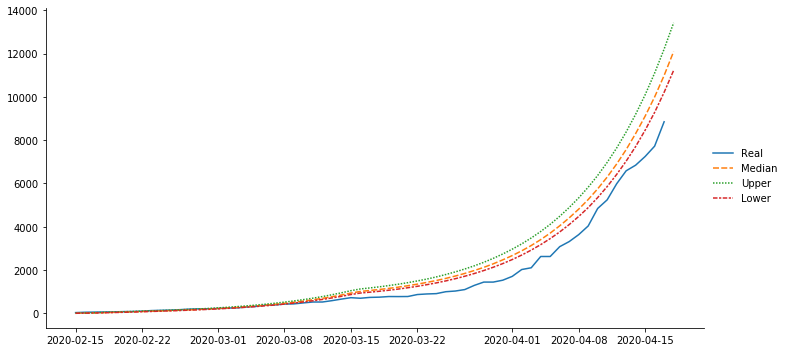

In [176]:
draw(I0, real=(confirmed-recovered)[country])

In [177]:
S.median(axis=1)[pd.to_datetime('2020-04-18')]

31541.572165721587

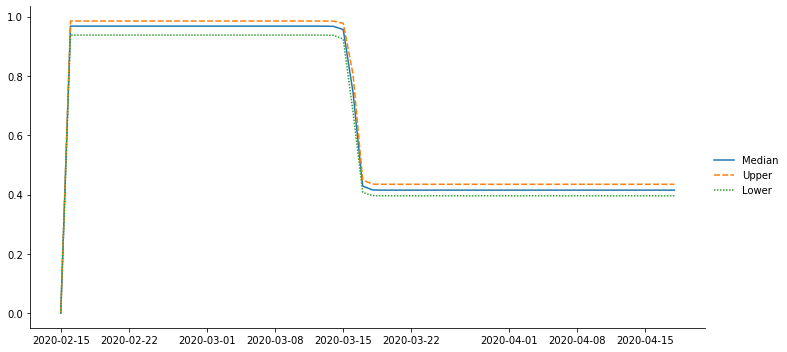

In [178]:
draw(q)

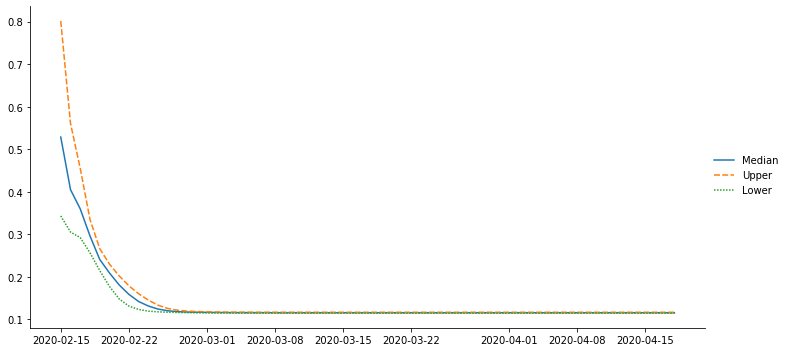

In [179]:
draw(b)

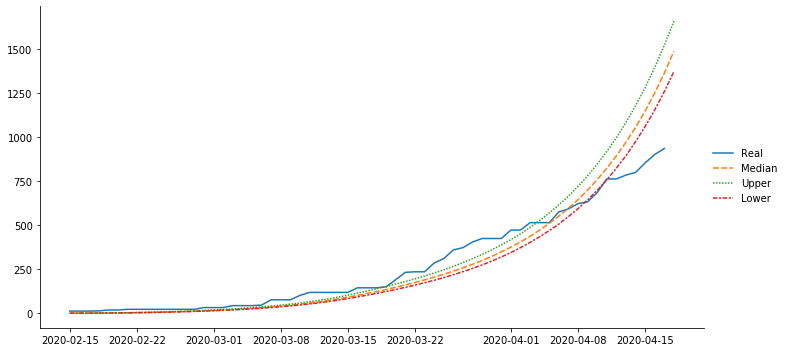

In [180]:
draw(R0, real=recovered[country])

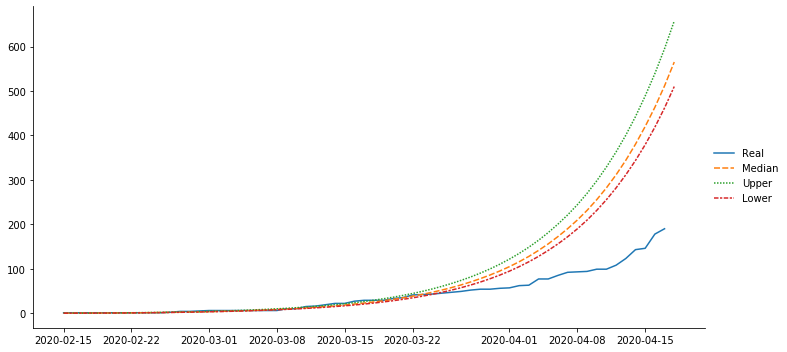

In [181]:
draw(D, real=death[country])

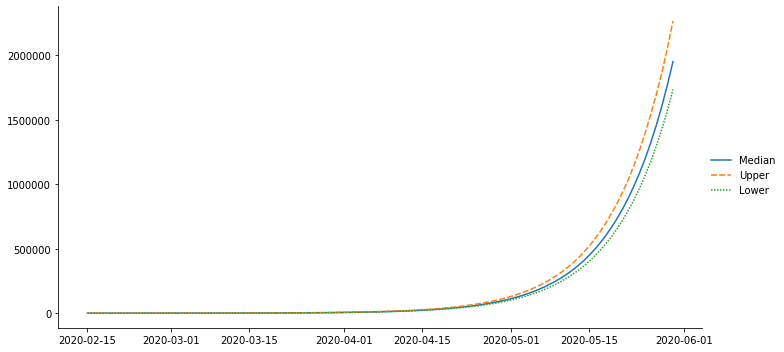

In [182]:
draw(S, upto=pd.to_datetime('2020-05-30'))

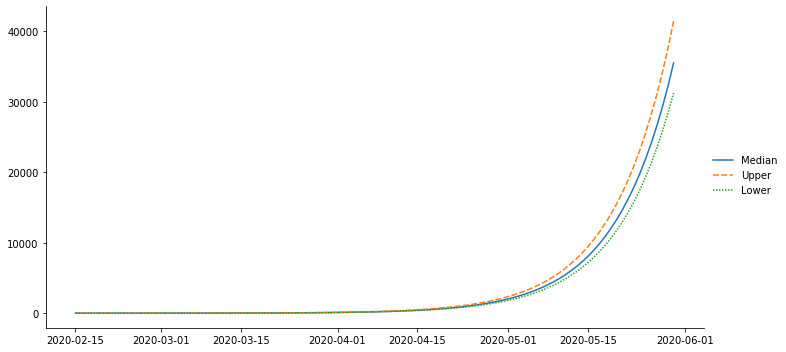

In [183]:
draw(D, upto=pd.to_datetime('2020-05-30'))

In [ ]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [ ]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [ ]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

In [ ]:
draw(cumulative, upto )

In [ ]:
### Other countris

In [79]:
country = 'Korea, South'
C0 = confirmed[country].values
R0 = (recovered)[country].values
D0 = death[country].values
P = 5170_0000
iter=2000
repeat = 1000
epoch = pd.to_datetime('2020-01-22')
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [80]:
# Train the model and generate samples
fit_q0_Korea = sm_q0.sampling(data=data, iter=iter, init=0)
fit_q0_Korea


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_64230a5b5384c44e11e41e1e07c52c66.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.92     2.3   3.84   0.16   2.42   6.46    8.6  13.11      3   1.86
b0         0.48    0.04   0.06   0.37   0.44    0.5   0.51   0.53      2   5.55
b1       1.3e-3  1.6e-3 2.4e-3 6.7e-6 8.1e-6 9.8e-6 1.1e-3 6.8e-3      2   4.37
theta_b    0.42    0.13   0.19   0.29   0.31   0.31   0.48   0.81      2   8.02
b_date    40.68    0.07   0.61  39.73  40.31  40.53  40.98  42.28     83   1.04
q0         0.03    0.04   0.06 1.9e-4 2.4e-4 2.8e-4 6.2e-3    0.2      3   2.13
q1         0.75    0.06   0.21   0.24   0.63   0.82   0.92   0.99     12   1.12
theta_q    0.76    0.47   0.68   0.36   0.37   0.38   0.79   2.31      2   4.52
q_date     64.5    8.46  11.97  43.61  55.57  71.12

In [81]:
# Train the model and generate samples
fit_0_Korea = sm_0.sampling(data=data, iter=iter, init=0)
fit_0_Korea


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7cd556a42c7edab6d498f94c1bcf71f7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   7.16    0.06   2.53    3.1   5.32   6.84    8.7  12.82   1996    1.0
b0         0.28  2.9e-4   0.01   0.26   0.27   0.28   0.28    0.3   1569    1.0
b1       5.6e-3  2.2e-5 8.1e-4 4.1e-3 5.0e-3 5.5e-3 6.1e-3 7.3e-3   1427    1.0
theta_b    0.42  2.3e-4   0.01    0.4   0.41   0.42   0.43   0.44   2116    1.0
b_date    39.29  6.6e-3   0.26  38.75  39.11  39.29  39.47   39.8   1586    1.0
q1         0.88  1.8e-3   0.11   0.58   0.83   0.91   0.96    1.0   3462    1.0
theta_q    0.15  1.7e-4 8.0e-3   0.14   0.15   0.15   0.16   0.17   2210    1.0
q_date    45.81    0.04   1.47  42.78  44.83  45.89  46.85  48.44   1528    1.0
a          0.03  5.8e-6 3.6e-4   0.03   0.03   0.03

In [ ]:
data_0_Korea = az.from_pystan(fit_0_Korea, log_likelihood='log_lik')
data_q0_Korea = az.from_pystan(fit_q0_Korea, log_likelihood='log_lik')

In [ ]:
az.compare({'start-0':data_0_Korea, 'start-q0':data_q0_Korea})

In [82]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit_0_Korea, 120)

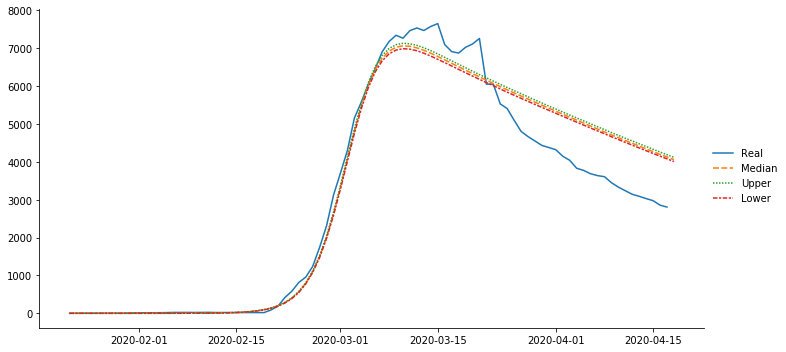

In [83]:
draw(I0, real=(confirmed-recovered)[country])

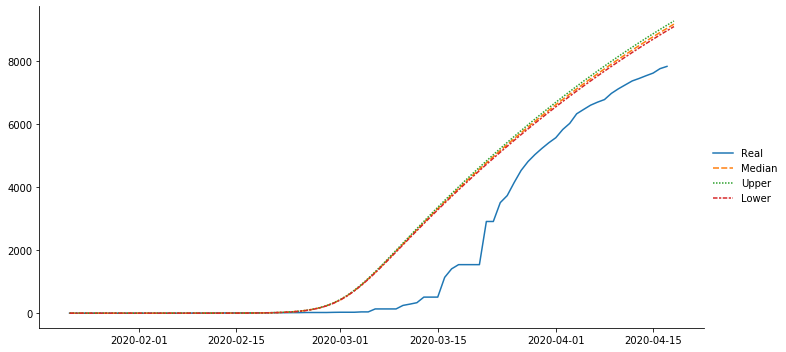

In [84]:
draw(R0, real=recovered[country])

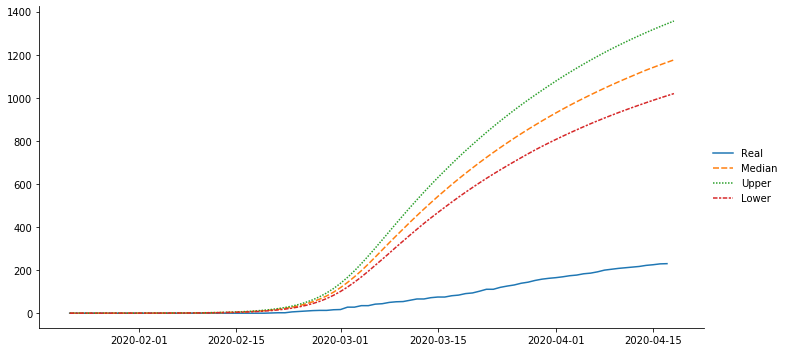

In [85]:
draw(D, real=death[country])

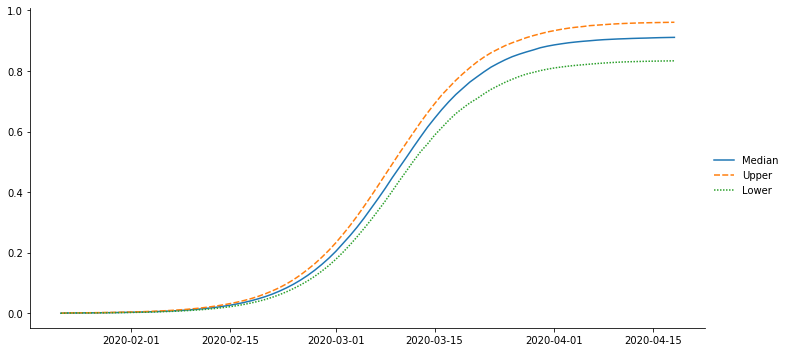

In [86]:
draw(q)

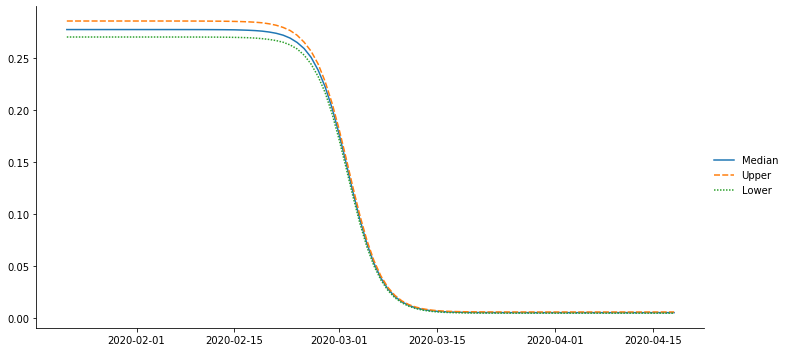

In [87]:
draw(b)

In [81]:
country = 'Italy'
epoch = pd.to_datetime('2020-02-01')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 6000_0000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}


In [82]:
fit_q0_Italy = sm_q0.sampling(data=data, iter=iter, init=0)
fit_q0_Italy

Inference for Stan model: anon_model_054b2e1c4d4a291c5a6d0677d680da52.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.06  2.0e-3    0.5   0.59   0.75   0.91    1.2   2.42  60589    1.0
b0         0.33  1.5e-5 4.9e-3   0.32   0.32   0.33   0.33   0.34 104637    1.0
b1         0.04  1.3e-6 4.2e-4   0.04   0.04   0.04   0.04   0.04 108982    1.0
theta_b    0.18  9.7e-6 3.0e-3   0.18   0.18   0.18   0.19   0.19  96836    1.0
b_date    47.29  6.3e-4   0.19  46.91  47.17   47.3  47.42  47.66  93815    1.0
q0          0.7  8.3e-4    0.2   0.27   0.55   0.73   0.87   0.99  60460    1.0
q1         0.45  5.4e-4   0.13   0.17   0.36   0.47   0.56   0.64  60714    1.0
theta_q    6.62  2.2e-3   0.91   5.08   5.98   6.53   7.16   8.64 169405    1.0
q_date    38.23  1.5e-4   0.06  38.12  38.18  38.22  38.26  38.35 156626    1.0
a    

In [83]:
fit_0_Italy = sm_0.sampling(data=data, iter=iter, init=0)
fit_0_Italy

Inference for Stan model: anon_model_b6525409ccd2ffd2d935a675ddd7f096.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    1.7    0.79   1.63   0.07   0.51   1.16   2.39   6.04      4   1.33
b0         4.47    3.19   4.64   1.37   1.69   1.96   5.65  15.22      2   4.18
b1         0.02    0.02   0.03 4.8e-3 5.6e-3 6.4e-3   0.04   0.07      2  18.86
theta_b    0.87    0.84   1.25   0.18   0.19    0.2   0.69   4.02      2   3.17
b_date    12.48    2.26   3.39   6.46   8.42  13.82  14.99  16.58      2   2.91
q1         0.26    0.11   0.23   0.01   0.03   0.21    0.4   0.79      5   1.31
theta_q     0.3    0.03   0.04   0.24   0.27   0.32   0.33   0.33      2   6.61
q_date    46.55    0.75   1.08  44.53  45.69  47.08  47.25  47.52      2   6.19
a          0.02  3.2e-6 9.2e-5   0.02   0.02   0.02   0.02   0.02    799   1.01
d    

In [84]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit_q0_Italy, 120)


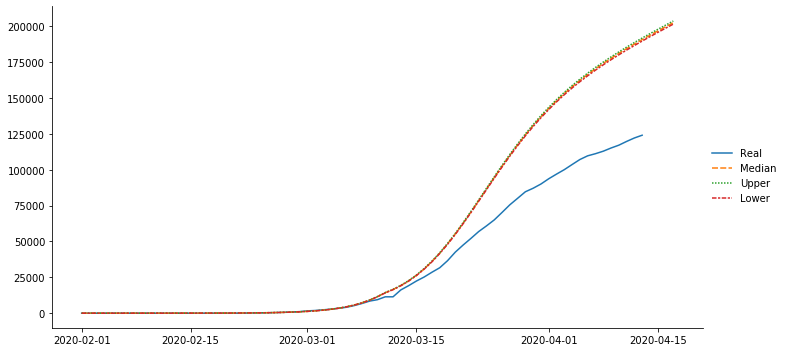

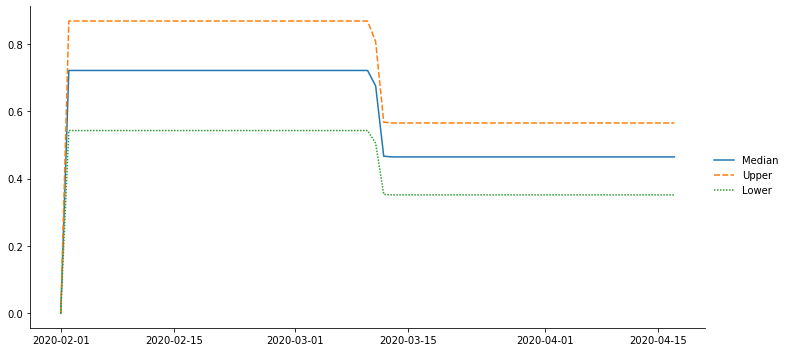

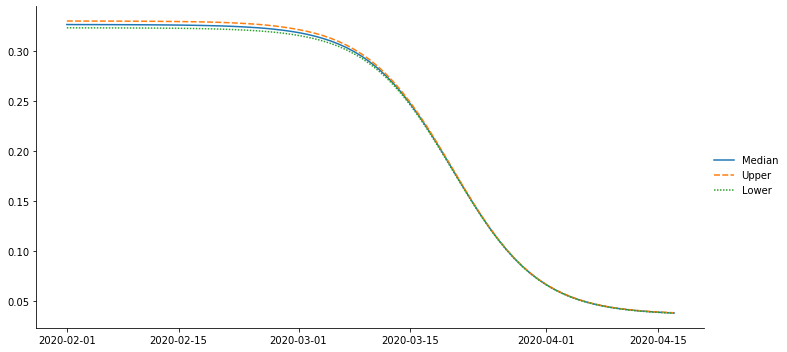

In [85]:
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)

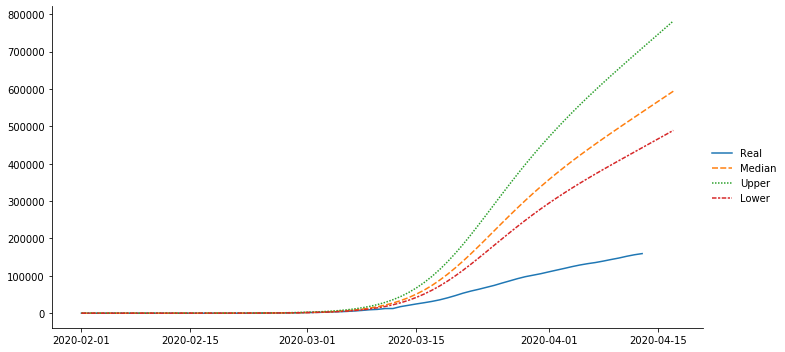

In [86]:
draw(S, real=(confirmed).loc[epoch:, country])

In [89]:
country = 'Israel'
epoch = pd.to_datetime('2020-02-21')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 6000_0000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit_q0_Israel = sm_q0.sampling(data=data, iter=iter, init=0)
fit_q0_Israel

Inference for Stan model: anon_model_054b2e1c4d4a291c5a6d0677d680da52.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.68  2.7e-3   0.73   0.69   1.17   1.54   2.02    3.5  75624    1.0
b0         0.34  8.6e-5   0.02    0.3   0.33   0.34   0.36   0.39  70756    1.0
b1         0.03  5.3e-6 1.7e-3   0.03   0.03   0.03   0.03   0.03  99787    1.0
theta_b     0.2  4.3e-5   0.01   0.18   0.19    0.2   0.21   0.23  75348    1.0
b_date    32.67  3.2e-3   0.87  30.86  32.11  32.71  33.27  34.26  71754    1.0
q0         0.24  2.3e-4   0.06   0.11    0.2   0.25   0.28   0.33  65902    1.0
q1         0.75  7.1e-4   0.18   0.34   0.63   0.78    0.9   0.99  65370    1.0
theta_q    8.78  2.7e-3   1.06    7.0   8.04   8.69   9.42  11.14 158274    1.0
q_date    33.38  1.4e-4   0.06  33.28  33.34  33.38  33.42   33.5 157447    1.0
a    

In [90]:
fit_0_Israel = sm_0.sampling(data=data, iter=iter, init=0)
fit_0_Israel

Inference for Stan model: anon_model_b6525409ccd2ffd2d935a675ddd7f096.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   4.14  9.6e-3    2.0    1.2   2.67   3.82   5.27   8.89  43808    1.0
b0         8.24    0.01   1.88   5.26   6.89   7.99   9.31  12.58  21163    1.0
b1         0.05  4.9e-5 6.1e-3   0.04   0.05   0.05   0.06   0.06  15256    1.0
theta_b    0.33  2.5e-4   0.03   0.27    0.3   0.32   0.34   0.39  15292    1.0
b_date     5.96  9.4e-3   1.29   3.39   5.09   5.97   6.84   8.45  18746    1.0
q1       8.6e-3  2.5e-5 3.0e-3 4.5e-3 6.5e-3 8.0e-310.0e-3   0.02  15211    1.0
theta_q    0.44  1.7e-4   0.02   0.41   0.43   0.44   0.46   0.48  13347    1.0
q_date    34.08  1.6e-3   0.23  33.66  33.93  34.08  34.23  34.56  19770    1.0
a          0.01  1.5e-6 3.4e-4   0.01   0.01   0.01   0.01   0.02  48169    1.0
d    

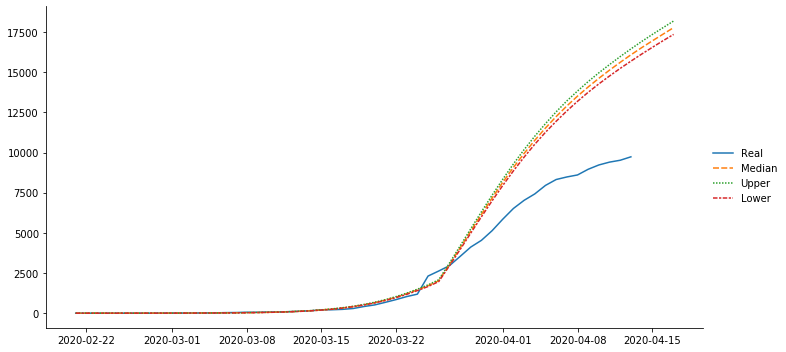

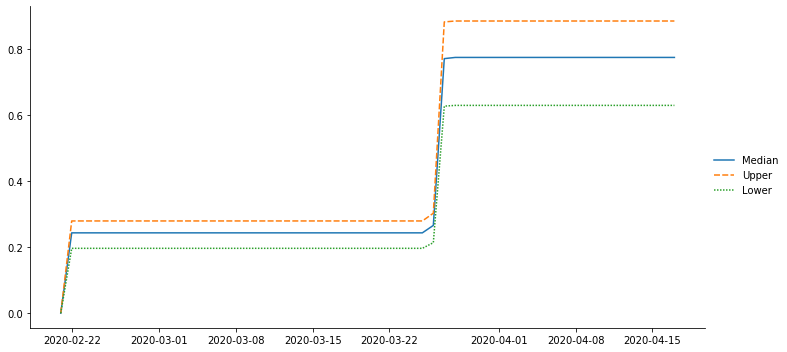

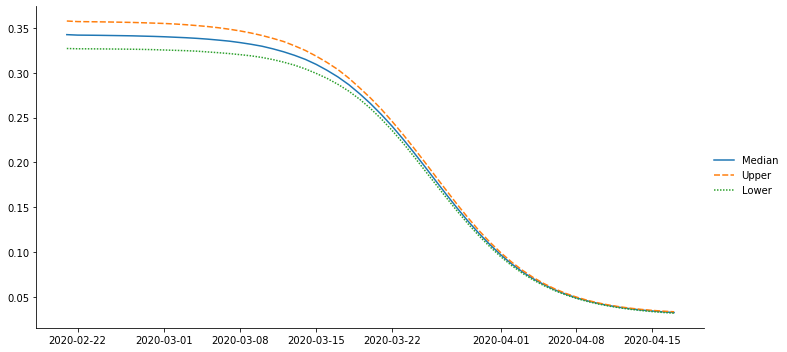

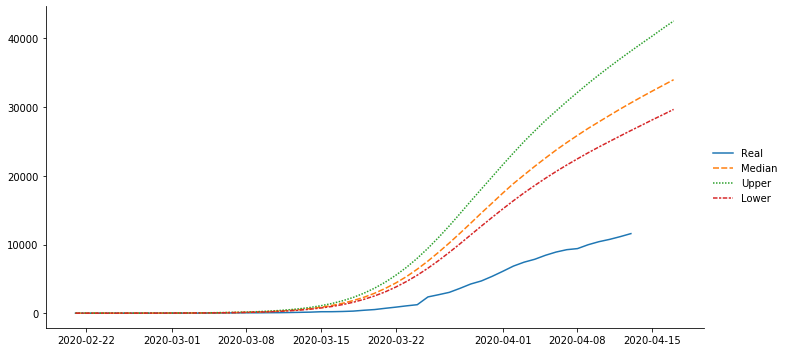

In [92]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit_q0_Israel, 120)
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)
draw(S, real=(confirmed).loc[epoch:, country])

In [93]:
country = 'US'
epoch = pd.to_datetime('2020-01-22')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 328_200_000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit_q0_US = sm_q0.sampling(data=data, iter=iter, init=0)
fit_q0_US

Inference for Stan model: anon_model_054b2e1c4d4a291c5a6d0677d680da52.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   6.62     4.7    6.9 2.0e-3   0.05   2.38  12.94  18.41      2   3.54
b0         0.36    0.04   0.05   0.31   0.31   0.34   0.41   0.45      2  10.27
b1       8.2e-4  3.6e-4 5.2e-41.9e-14 5.5e-4 9.5e-4 1.3e-3 1.5e-3      2   4.27
theta_b    0.52    0.28   0.39   0.11   0.22   0.41    0.8    1.2      2  34.53
b_date    61.98    2.92   4.13  57.79  57.93  61.49  65.58  67.59      2  24.76
q0         0.06    0.07   0.11 1.6e-4 2.0e-4 2.6e-4 5.3e-3   0.38      2   2.24
q1         0.82    0.11   0.21    0.2   0.77    0.9   0.96    1.0      4   1.47
theta_q    3.41    3.31    4.7   0.47   0.48   0.82   5.06  12.93      2   9.05
q_date    68.16    4.38   6.19  57.41   63.5  71.24  72.13  72.49      2  42.76
a    

In [94]:
fit_0_US = sm_0.sampling(data=data, iter=iter, init=0)
fit_0_US

Inference for Stan model: anon_model_b6525409ccd2ffd2d935a675ddd7f096.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   4.11    0.04   1.99   1.23   2.65   3.77   5.22   8.87   3139    1.0
b0         7.31    0.05   2.12   4.02   5.75   7.04   8.59  12.12   1491    1.0
b1       6.2e-3  1.8e-5 6.5e-4 4.9e-3 5.7e-3 6.2e-3 6.6e-3 7.5e-3   1259   1.01
theta_b    0.77  5.1e-3   0.19   0.51   0.64   0.73   0.85   1.22   1425    1.0
b_date     7.39    0.04   1.23   5.24   6.51    7.3   8.17   10.0   1202    1.0
q1         0.68  3.2e-3   0.17   0.32   0.57    0.7   0.81   0.95   2723    1.0
theta_q     0.3  2.6e-5 1.0e-3   0.29    0.3    0.3    0.3    0.3   1529   1.01
q_date    65.58  2.0e-3   0.07  65.44  65.53  65.57  65.62  65.71   1120   1.01
a        8.3e-3  7.4e-7 4.0e-5 8.2e-3 8.2e-3 8.3e-3 8.3e-3 8.3e-3   2892    1.0
d    

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


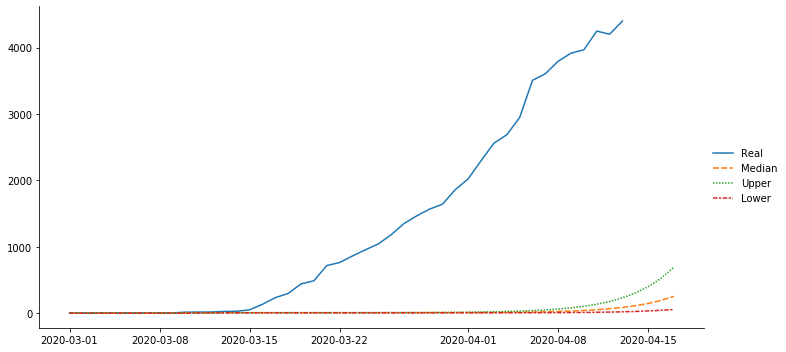

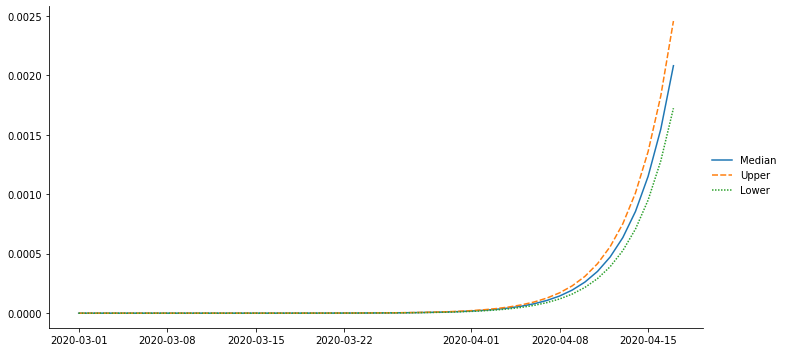

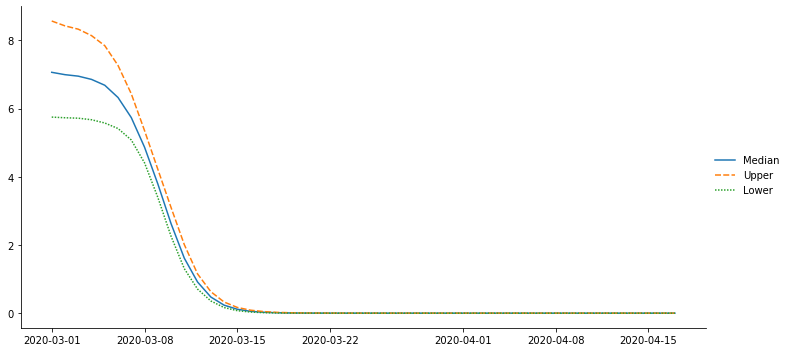

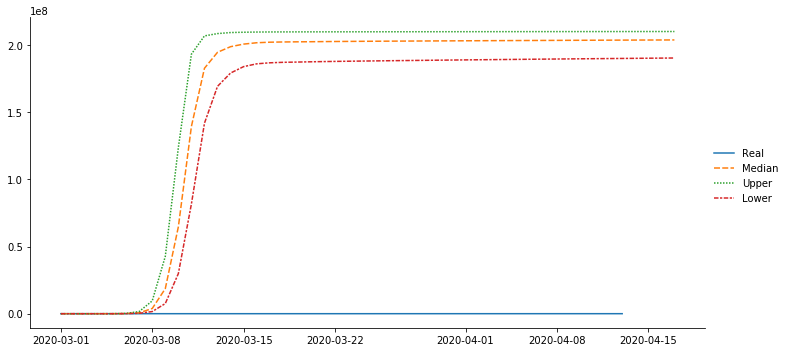

In [106]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit_0_US, 120)
draw(I0, real=(confirmed-recovered).loc[epoch:, country])
draw(q)
draw(b)
draw(S, real=(confirmed).loc[epoch:, country])

In [105]:
country = 'Pakistan'
epoch = pd.to_datetime('2020-03-01')
C0 = confirmed.loc[epoch:, country].values
R0 = (recovered).loc[epoch:, country].values
D0 = death.loc[epoch:, country].values
P = 212_200_000
iter=100000
repeat = 1000
data = {'T': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
fit_q0_Pakistan = sm_q0.sampling(data=data, iter=iter, init=0)
fit_q0_Pakistan

Inference for Stan model: anon_model_054b2e1c4d4a291c5a6d0677d680da52.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.04    3.44   5.21    0.4   1.44   2.61   7.36  17.59      2   2.65
b0          1.1     0.2   0.31    0.5    0.9   1.19   1.31   1.54      2   2.56
b1       1.9e-3  1.3e-3 6.0e-31.1e-11 2.6e-4 5.3e-4 1.0e-3   0.02     21   1.08
theta_b    0.29     0.1   0.14   0.05   0.15   0.36   0.39   0.44      2   4.51
b_date    13.56    3.91   5.78   0.52  14.74  16.55   17.0  17.65      2   3.34
q0         0.03    0.03   0.05 2.6e-4 8.3e-4 1.7e-3   0.04   0.15      2   4.29
q1         0.81    0.06   0.18   0.35   0.71   0.87   0.95    1.0     10   1.11
theta_q    1.24    0.86   1.26   0.49   0.53   0.56   0.99   4.34      2   3.49
q_date    30.91    6.48   9.18  14.86  22.62   36.0  36.45  37.11      2  20.96
a    

In [ ]:
fit_0_Pakistan = sm_0.sampling(data=data, iter=iter, init=0)
fit_0_Pakistan